## 2.2 Modeling quality: 1. [medium, small | large] size tubers
### The data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats as stats
import time # Show computation time
np.random.seed(seed = 505730)

Custom function to generate a grid with all possible combinations of vectors in a dictionnary (source: [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html?highlight=expand_grid#creating-example-data)).

In [2]:
import itertools
def expand_grid(data_dict):
   rows = itertools.product(*data_dict.values())
   return pd.DataFrame.from_records(rows, columns = data_dict.keys())

Load data.

In [3]:
df_ml = pd.read_csv('output/df_tuberSize.csv')
df_ml.columns

Index(['tsizeMS_L', 'tsizeS_M', 'NoEssai', 'NoBloc', 'NoTraitement', 'ID',
       'ID_bl', 'DensitePlants', 'PrecCropFiveClasses', 'Cultivar',
       'Maturity5', 'growing.season', 'temp_moy_5years', 'prec_tot_5years',
       'sdi_5years', 'gdd_5years', 'NtotDose', 'PtotDose', 'KtotDose',
       'soilTextIlr1', 'soilTextIlr2', 'soilTextIlr3', 'soilTypeIlr1_3',
       'soilTypeIlr2_3', 'soil_pH', 'soil_P1_Fv.AlP', 'soil_P1_Al.P',
       'soil_K2_FvMgCa.K', 'soil_K2_Fv.MgCa', 'soil_K2_Mg.Ca', 'soil_P',
       'soil_K', 'soil_Al', 'ISP1', 'test_type'],
      dtype='object')

I create vectors categorizing response and predictors.

In [4]:
num_vars = ['DensitePlants', 'growing.season',
            'temp_moy_5years', 'prec_tot_5years', 'sdi_5years', 'gdd_5years',
            'NtotDose', 'PtotDose', 'KtotDose',
            'soilTextIlr1', 'soilTextIlr2', 'soilTextIlr3',
            'soilTypeIlr1_3', 'soilTypeIlr2_3',
            'soil_pH', 
            'soil_P1_Fv.AlP', 'soil_P1_Al.P', 'soil_K2_FvMgCa.K', 'soil_K2_Fv.MgCa', 'soil_K2_Mg.Ca']
cat_vars = ['PrecCropFiveClasses']
resp_vars = ['tsizeMS_L']
dose_vars = ['NtotDose', 'PtotDose', 'KtotDose']

In __N__ tests, __P__ and __K__ doses are in excess, which drags recommandations upwards. In all N tests, we set the __P__ and __K__ doses according to the CRAAQ fertilisation guide. The next cells are used to correct abnormally high non-limiting __P__ and __K__ dosage for some trials.

In [5]:
def craaq_P(x): # x, ISP
    if x <= 2.5:
        recommandation = 200
    elif x <= 5:
        recommandation = 150
    elif x <= 10:
        recommandation = 150
    elif x <= 15:
        recommandation = 120
    elif x <= 25:
        recommandation = 75
    else:
        recommandation = 50
    return recommandation

In [6]:
def craaq_K(x): # x, K in kg K_M3 / ha
    if x <= 75:
        recommandation = 240
    elif x <= 150:
        recommandation = 215
    elif x <= 225:
        recommandation = 160
    elif x <= 300:
        recommandation = 120
    elif x <= 375:
        recommandation = 80
    elif x <= 450:
        recommandation = 50
    else:
        recommandation = 20
    return recommandation

In [7]:
df_ml.loc[df_ml.test_type == 'N', "PtotDose"] = df_ml.ISP1.apply(lambda x: craaq_P(x))
df_ml.loc[df_ml.test_type == 'N', "KtotDose"] = df_ml.soil_K.apply(lambda x: craaq_K(x)) 

df_ml.loc[df_ml.test_type.isna(), "PtotDose"] = df_ml.ISP1.apply(lambda x: craaq_P(x))
df_ml.loc[df_ml.test_type.isna(), "KtotDose"] = df_ml.soil_K.apply(lambda x: craaq_K(x)) 

df_ml.loc[df_ml.test_type == 'P', "KtotDose"] = df_ml.soil_K.apply(lambda x: craaq_K(x))
df_ml.loc[df_ml.test_type == 'K', "PtotDose"] = df_ml.ISP1.apply(lambda x: craaq_P(x))

Verify max doses per element: N-P-K respectively, and drop other useless columns (related to soil elements and trial identifiers).

In [8]:
np.max(df_ml.NtotDose), np.max(df_ml.PtotDose), np.max(df_ml.KtotDose)

(250.0, 300.0, 300.0)

In [9]:
id_table = df_ml[['ID', 'NoEssai', 'NoBloc','ID_bl', 'NoTraitement', 'test_type']]
id_table.index = df_ml.index
soil_table = df_ml[['soil_P', 'soil_Al', 'soil_K', 'ISP1']]
soil_table.index = df_ml.index
df_ml = df_ml.drop(['ID', 'NoEssai', 'NoBloc', 'ID_bl', 'NoTraitement', 'soil_P', 'soil_Al', 'soil_K', 'ISP1', 'tsizeS_M'], axis = 1)

I use the `panda.get_dummies()` function to transform each categorical feature with **m** possible values into **m** binary features, *with only one active*. The output will be a sparse matrix where each column corresponds to one possible value of one feature: one (__1__) indicates category membership; otherwise zero (__0__) is indicated.

In [10]:
df_ml["PrecCropFiveClasses"] = df_ml["PrecCropFiveClasses"].astype('category')
df_ml["test_type"] = df_ml["test_type"].astype('category')
df_ml["Cultivar"] = df_ml["Cultivar"].astype('category')
df_ml["Maturity5"] = df_ml["Maturity5"].astype('category')

In [11]:
df_ml = pd.get_dummies(df_ml, columns = ["PrecCropFiveClasses"])
df_ml = pd.get_dummies(df_ml, columns = ["test_type"])
df_ml = pd.get_dummies(df_ml, columns = ["Cultivar"])
df_ml = pd.get_dummies(df_ml, columns = ["Maturity5"])

If `test_type`, `Cultivar` or `Maturity5` variables should be removed before modeling, the next cell is activated or not:

In [12]:
df_ml = df_ml.loc[:, ~df_ml.columns.str.startswith('test_type')]
df_ml = df_ml.loc[:, ~df_ml.columns.str.startswith('Cultivar')]
df_ml = df_ml.loc[:, ~df_ml.columns.str.startswith('Maturity5')]

### Data set __train__ and __test__ split

If we need to predict a whole dose-response curve, we need to split by trials.

The split proportions are set to obtain __~70% of data__ in the training set. This kind of split is the most robust since the training and test sets are independant data. I split at _bloc level_. This split allows to mix data from the same experimental plots, but on different blocks. Data in both sets are independant, but because blocks are similar units the model might behave wrongly on new sites with less usual data.

In [13]:
np.random.seed(seed = 48327)
blocks = id_table['ID_bl']
N_blocks = blocks[id_table.test_type == 'N'].unique()
N_blocks_inTrain = np.random.choice(a = N_blocks, 
                                    size = np.around(0.7 * len(N_blocks)).astype(int), 
                                    replace = False)

P_blocks = blocks[id_table.test_type == 'P'].unique()
P_blocks_inTrain = np.random.choice(a = P_blocks, 
                                    size = np.around(0.7 * len(P_blocks)).astype(int), 
                                    replace = False)

K_blocks = blocks[id_table.test_type == 'K'].unique()
K_blocks_inTrain = np.random.choice(a = K_blocks, 
                                    size = np.around(0.7 * len(K_blocks)).astype(int), 
                                    replace = False)

npk_blocks = blocks[id_table.test_type == 'NPK'].unique()
npk_blocks_inTrain = np.random.choice(a = npk_blocks, 
                                      size = np.around(len(npk_blocks) * 0.7).astype(int), 
                                      replace = False)

na_blocks = blocks[id_table.test_type.isna()].unique()
na_blocks_inTrain = np.random.choice(a = na_blocks, 
                                     size = np.around(len(na_blocks) * 0.7).astype(int), 
                                     replace = False)

In [14]:
blocks_inTrain = np.concatenate([N_blocks_inTrain, 
                                 P_blocks_inTrain, 
                                 K_blocks_inTrain, 
                                 npk_blocks_inTrain, 
                                 na_blocks_inTrain])

blocks_inTest = blocks[~blocks.isin(blocks_inTrain)].unique()

Numerical variables are scaled before modeling. Both predictive and response variables are set to null (__0__) mean and unit (__1__) variance using the training set mean and standard error. This chunk computes the mean and standard error of predictive variables.

In [15]:
mean_numvars = df_ml.loc[blocks.isin(blocks_inTrain), num_vars].apply(axis = 0, func = np.mean)
std_numvars = df_ml.loc[blocks.isin(blocks_inTrain), num_vars].apply(axis = 0, func = np.std)
df_ml_sc = df_ml.copy()
for var in num_vars:
    df_ml_sc[var] = (df_ml[var] - df_ml.loc[blocks.isin(blocks_inTrain), var].mean()) / df_ml.loc[blocks.isin(blocks_inTrain), var].std()

The response is also scaled:

In [16]:
mean_respvars = df_ml.loc[blocks.isin(blocks_inTrain), resp_vars].mean()
std_respvars = df_ml.loc[blocks.isin(blocks_inTrain), resp_vars].std()
for var in resp_vars:
    df_ml_sc[var] = (df_ml[var] - mean_respvars[var]) / std_respvars[var]

In [17]:
#min_respvars = df_ml.loc[blocks.isin(blocks_inTrain), resp_vars].min()
#max_respvars = df_ml.loc[blocks.isin(blocks_inTrain), resp_vars].max()
#mean_respvars[0], std_respvars[0], min_respvars[0], max_respvars[0]

Then, separate train and test arrays are created for predictive and response variables.

In [18]:
X_train = df_ml_sc.loc[blocks.isin(blocks_inTrain), df_ml.columns.isin(num_vars) | df_ml.columns.str.startswith(cat_vars[0])].values
X_test = df_ml_sc.loc[~blocks.isin(blocks_inTrain), df_ml.columns.isin(num_vars) | df_ml.columns.str.startswith(cat_vars[0])].values
Y_train = df_ml_sc[resp_vars][blocks.isin(blocks_inTrain)].values
Y_test = df_ml_sc[resp_vars][~blocks.isin(blocks_inTrain)].values

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3203, 25), (1354, 25), (3203, 1), (1354, 1))

Let's check the proportion of data in the traning set:

In [20]:
round(df_ml.loc[blocks.isin(blocks_inTrain)].shape[0]/df_ml.shape[0], 3)

0.703

### Feature importance

I use the python scikit-learn _ExtraTreesRegressor_ algorithm to select features that contributed most as predictive variables. The process ranks features importance.

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
import altair as alt
fs_reg = ExtraTreesRegressor(n_estimators = 50)
fs_reg.fit(X_train, Y_train.ravel())

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

There is a need to show column names in English rather than their names in the data frame. We created a `csv` as translation table (`translate_col2.csv`). This table is merged to the variable importance table, which is then ranked and plotted.

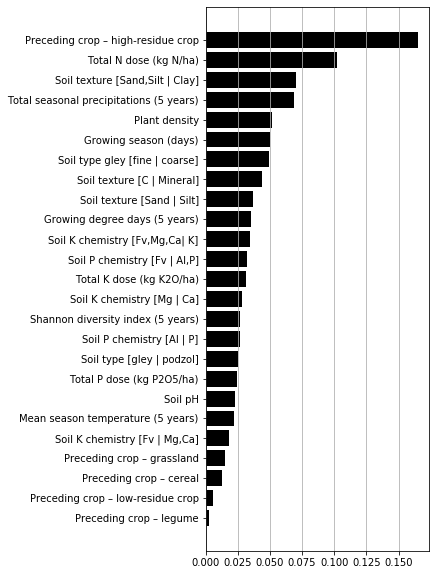

In [22]:
rf_varimp = pd.DataFrame({'columns': df_ml_sc.drop('tsizeMS_L', axis = 1).columns, 
                          'importance': fs_reg.feature_importances_})
translate_columns = pd.read_csv("csv/translate_col2.csv")
rf_varimp_en = pd.merge(rf_varimp,
                        translate_columns.drop("fr", axis = 1),
                        on = "columns", how = 'left').\
  sort_values(by = ["importance"])
rf_varimp_en.to_csv('output/varImp_ilrSML.csv', index_label = "ID") # common plot (in 1.4.1)

plt.figure(figsize = (4, 10))
plt.barh(rf_varimp_en.en, rf_varimp_en.importance, color = "black");
plt.grid(axis = 'x')

The preceeding crop categories could be removed.

In [23]:
remove_var_names = ['PrecCropFiveClasses_Cereal',
                    'PrecCropFiveClasses_Grassland',
                    'PrecCropFiveClasses_HRC',
                    'PrecCropFiveClasses_LRC',
                    'PrecCropFiveClasses_Legume']
keep_vars = ~ df_ml_sc.drop('tsizeMS_L', axis = 1).columns.isin(remove_var_names)
X_train = X_train[:, keep_vars]
X_test = X_test[:, keep_vars]

### Modeling
#### _General packages_

In [24]:
#from sklearn.model_selection import GridSearchCV # Grid Search
from sklearn.model_selection import RandomizedSearchCV # Random Search
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pprint import pprint # print default parameters of models

### k-nearest neighbors (knn) algorithm
#### _The default parameters_

In [25]:
from sklearn.neighbors import KNeighborsRegressor

In [26]:
knn_reg = KNeighborsRegressor()
print('Parameters currently in use:\n')
pprint(knn_reg.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


#### _Optimisation (paraneters tuning)_

In [27]:
knn_param = {'n_neighbors': stats.randint(3, 20), 
             'weights': ['uniform', 'distance']}
n_iter_search = 50

In [28]:
print("\nRunning random search to tune up KNN hyperparameters ...")
start_time = time.time()
knn_random_search = RandomizedSearchCV(estimator = knn_reg, param_distributions = knn_param, n_iter = n_iter_search, cv = 5, n_jobs = -1)
knn_random_search.fit(X_train, Y_train)
print("Duration: %s secondes ---" % (time.time() - start_time))
knn_random_search.best_estimator_


Running random search to tune up KNN hyperparameters ...
Duration: 10.514766693115234 secondes ---


C:\Users\zcoul\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                    weights='uniform')

#### _The __knn__ model_

In [29]:
knn_reg = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                              metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                              weights='uniform')
knn = knn_reg.fit(X_train, Y_train)

Performance in train and test

In [30]:
Y_train_obs = df_ml[resp_vars][blocks.isin(blocks_inTrain)].values
Y_test_obs = df_ml[resp_vars][~blocks.isin(blocks_inTrain)].values

In [31]:
Y_train_predknn = knn.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_predknn = knn.predict(X_test) * std_respvars.values + mean_respvars.values

In [32]:
index = ['k-nearest neighbors']
knn_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, knn.predict(X_train)).round(3),
                           "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_predknn).round(4),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_predknn)).round(4),
                           "Test_R2": r2_score(Y_test, knn.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_predknn).round(4),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_predknn)).round(4)}, 
                           index = index)
knn_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
k-nearest neighbors,0.716,0.7144,0.9811,0.551,0.9069,1.183


The __knn__ ressults plot

Text(0.5, 1.0, 'Test')

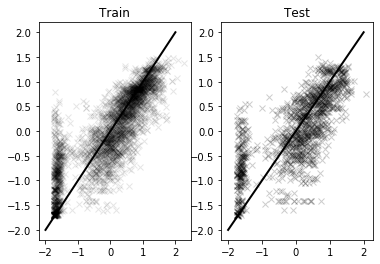

In [33]:
plt.subplot(1, 2, 1)
plt.plot(Y_train, knn.predict(X_train), 
         marker = 'x', color = 'black', linestyle = 'None', alpha = 0.1)
plt.plot([-2, 2], [-2, 2], color = 'black', linewidth = 2)
plt.title('Train')

plt.subplot(1, 2, 2)
plt.plot(Y_test, knn.predict(X_test), 
         marker = 'x', color = 'black', linestyle = 'None', alpha = 0.2)
plt.plot([-2, 2], [-2, 2], color = 'black', linewidth = 2)
plt.title('Test')

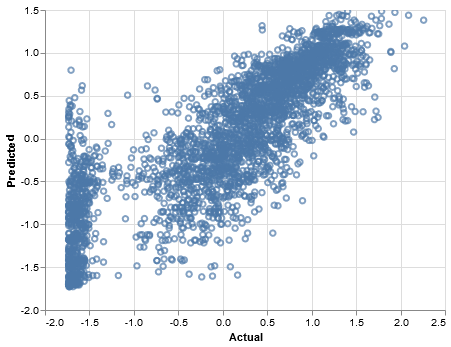

In [34]:
import altair as alt
alt.Chart(pd.DataFrame({"Actual": Y_train[:,0],
                        "Predicted": knn.predict(X_train)[:,0]})).\
  mark_point().\
  encode(x="Actual", y = "Predicted", tooltip=['Actual', 'Predicted']).\
  interactive()

### Random forest __RF__ algorithm
#### _The default parameters_

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
rf_reg = RandomForestRegressor(random_state = 1)
print('Parameters currently in use:\n')
pprint(rf_reg.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


#### _Optimisation_
The most important settings are the number of trees in the forest (`n_estimators`) and the number of features considered for splitting at each leaf node (`max_features`). The `max_features` is set to its default value `'auto'`, while I try out a wide range of values to see what works for `n_estimators`.

#### _The best parameters_
The best parameters from fitting the random search could be viewed with `rf_random_search.best_estimator_`. They are stored in the raw chunk below.

#### _The optimal model_

In [37]:
rf_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=12,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)
rfm = rf_reg.fit(X_train, Y_train.ravel())

Performance in train and test (rfm)

In [38]:
Y_train_predrf = rfm.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_predrf =  rfm.predict(X_test) * std_respvars.values + mean_respvars.values

In [39]:
index = ['Random forest']
rf_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, rfm.predict(X_train)).round(3), 
                          "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_predrf).round(4),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_predrf)).round(4),
                           "Test_R2": r2_score(Y_test, rfm.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_predrf).round(4),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_predrf)).round(4)}, 
                          index = index)
rf_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
Random forest,0.873,0.3942,0.6571,0.571,0.8174,1.156


The __rf__ ressults plot

Text(0.5, 0, 'Mesured yield ($Mg ha^{-1})$')

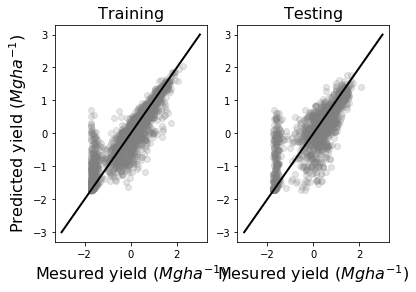

In [40]:
#fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(Y_train, rfm.predict(X_train), marker = 'o', color = 'grey', linestyle = 'None', alpha = 0.2)
plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
plt.title('Training', fontsize = 16)
plt.xlabel(r'Mesured yield ($Mg ha^{-1})$', fontsize = 16)
plt.ylabel(r'Predicted yield ($Mg ha^{-1})$', fontsize = 16)

plt.subplot(1, 2, 2)
plt.plot(Y_test, rfm.predict(X_test), marker = 'o', color = 'grey', linestyle = 'None', alpha = 0.2)
plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
plt.title('Testing', fontsize = 16)
plt.xlabel(r'Mesured yield ($Mg ha^{-1})$', fontsize = 16)

### Neural Networks __NN__
#### _The default parameters_

In [41]:
from sklearn.neural_network import MLPRegressor

In [42]:
nn_reg = MLPRegressor(max_iter = 500)
print('Parameters currently in use:\n')
pprint(nn_reg.get_params())

Parameters currently in use:

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


#### _Optimization_ 

#### _The optimal network_

In [43]:
nn_reg = MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=200, learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)
nn = nn_reg.fit(X_train, Y_train.ravel())

The __nn__ performance in train and test

In [44]:
Y_train_prednn = nn.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_prednn =  nn.predict(X_test) * std_respvars.values + mean_respvars.values

In [45]:
index = ['Neural networks']
nn_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, nn.predict(X_train)).round(3), 
                           "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_prednn).round(4),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_prednn)).round(4),
                           "Test_R2": r2_score(Y_test, nn.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_prednn).round(4),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_prednn)).round(4)}, 
                           index = index)
nn_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
Neural networks,0.729,0.7063,0.9594,0.57,0.8627,1.1582


The network ressults plot

Text(0.5, 1.0, 'Test')

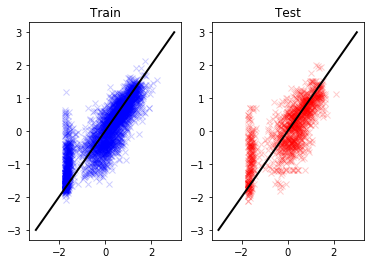

In [46]:
plt.subplot(1, 2, 1)
plt.plot(Y_train, nn.predict(X_train), marker = 'x', color = 'blue', linestyle = 'None', alpha = 0.2)
plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
plt.title('Train')

plt.subplot(1, 2, 2)
plt.plot(Y_test, nn.predict(X_test), marker = 'x', color = 'red', linestyle = 'None', alpha = 0.2)
plt.plot([-3, 3], [-3, 3], color='black', linewidth=2)
plt.title('Test')

### Gaussian process __GP__ model 
#### _The default parameters_

In [47]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [48]:
gp_reg = GaussianProcessRegressor()
print('Parameters currently in use:\n')
pprint(gp_reg.get_params())

Parameters currently in use:

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}


#### _Optimisation_

In [49]:
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel

The optimal __gp__ model

Once the model has been optimized, I ran it again with more restarts. The __gp__ object (the model) was run then exported as a joblib file. To avoid fitting the model on each kernel restart, the fitting has been greyed out in favor of an import of the joblib file.

In [50]:
gp_reg = GaussianProcessRegressor(alpha=0.13643611525341148, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
gpl = gp_reg.fit(X_train, Y_train) # gpl 'l' for ratio with large size tubers.

The __gp__ performance in train and test

In [51]:
Y_train_predgp = gpl.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_predgp =  gpl.predict(X_test) * std_respvars.values + mean_respvars.values

In [52]:
index = ['Gaussian processes']
gp_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, gpl.predict(X_train)).round(3), 
                          "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_predgp).round(4),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_predgp)).round(4),
                           "Test_R2": r2_score(Y_test, gpl.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_predgp).round(4),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_predgp)).round(4)}, 
                           index = index)
gp_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
Gaussian processes,0.831,0.5076,0.7566,0.643,0.7613,1.0553


The __gp__ ressults plot

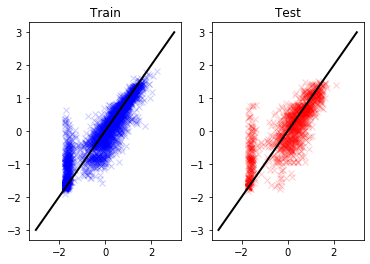

In [53]:
counter = 1
for i in range(len(resp_vars)):
    plt.subplot(len(resp_vars), 2, counter)
    plt.plot(Y_train[:, 0], gpl.predict(X_train), marker = 'x', color = 'blue', linestyle = 'None', alpha = 0.2)
    plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
    plt.title('Train')

    plt.subplot(1, 2, counter + 1)
    plt.plot(Y_test[:, 0], gpl.predict(X_test), marker = 'x', color = 'red', linestyle = 'None', alpha = 0.2)
    plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
    plt.title('Test')
    
    counter = counter + 1

This chain concatenates scores of the models

In [54]:
scoresTsmsl = pd.concat([knn_scores, rf_scores, nn_scores, gp_scores], axis = 0, ignore_index = False)
scoresTsmsl['Target'] = '[M, S | L]'
scoresTsmsl.to_csv('output/scoresTsmsl.csv')
scoresTsmsl

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE,Target
k-nearest neighbors,0.716,0.7144,0.9811,0.551,0.9069,1.1830,"[M, S | L]"
Random forest,0.873,0.3942,0.6571,0.571,0.8174,1.1560,"[M, S | L]"
Neural networks,0.729,0.7063,0.9594,0.570,0.8627,1.1582,"[M, S | L]"
Gaussian processes,0.831,0.5076,0.7566,0.643,0.7613,1.0553,"[M, S | L]"


### Point estimation: prediction of agronomic optimal __NPK__ dosage

#### Create a table to model

The same random row used in the preceding notebook `1.4.1_ml-marketable-yield-model.ipynb` is repoted here as the example where the model is used for diagnosis. The row is referenced by its index.

In [55]:
r_sample = pd.read_csv('output/r_sample.csv')
r_sample = id_table.loc[id_table.ID == r_sample.ID.values[0], ["NoEssai", "test_type", "ID"]]
r_sample

,NoEssai,test_type,ID
2304,194,P,194-2-4


In [56]:
# Verify the row index
index = r_sample.index[0]
index

2304

We grab this row with only the columns we need for modeling from the `df_ml_sc` table, which is already on the right scale for modeling.

In [57]:
reference_row = df_ml_sc.loc[df_ml_sc.index == index, df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]
NoEssai = id_table.loc[df_ml_sc.index == index].NoEssai.values[0]

Here, we need to maximise the proportion of medium size tuber aiming to yield maximum tubers for table (market). There are no economic considerations. The optimal doses are the NPK combination where the computed ilr values reach the maximum.

Instead of generating a grid of values (which is numerically inefficient), we generate random NPK doses from uniform distributions on plausible doses. The `random.uniform()` function gives a random floating point number in a given range.

In [58]:
n_grid_samples = 1000
N_range = [0, 250]
P_range = [0, 250]
K_range = [0, 250]

np.random.seed(936492)
dose_grid = pd.DataFrame({'NtotDose': np.random.uniform(N_range[0], N_range[1], n_grid_samples),
                          'PtotDose': np.random.uniform(P_range[0], P_range[1], n_grid_samples),
                          'KtotDose': np.random.uniform(K_range[0], K_range[1], n_grid_samples)})

Doses are variables among others, and also need to be scaled on the scale on which they were put in to create the model.

In [59]:
dose_grid_sc = dose_grid.copy()
#dose_vars = dose_grid.columns
for var in dose_vars:
    dose_grid_sc[var] = (dose_grid[var] - mean_numvars[var]) / std_numvars[var]

The last part to create the table is to stack the observation (randomly slected previously) a number of times equal to the `dose_grid` table, so that it conveys the same information at each row. Then we replace only NPK doses with the one sampled randomly.

In [60]:
reference_stack = pd.DataFrame(index = range(dose_grid.shape[0]), columns = reference_row.columns)
for i in range(reference_stack.shape[1]):
    reference_stack.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack.shape[0])
reference_stack.NtotDose = dose_grid_sc.NtotDose
reference_stack.PtotDose = dose_grid_sc.PtotDose
reference_stack.KtotDose = dose_grid_sc.KtotDose    

The yield proportion is predicted based on the table, then put back to its original scale and inserted in the `dose_grid` table.

### Prediction with __knn__ model

In [61]:
ilr_sc = knn.predict(reference_stack)
dose_grid["ilr_"] = ilr_sc[:, 0] * std_respvars.values + mean_respvars.values

We isolate the row where `ilr_` is maximum.

In [62]:
opt_doses_knn = dose_grid.loc[dose_grid["ilr_"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "ilr_"]].round(2)
opt_doses_knn

NtotDose    245.82
PtotDose     11.75
KtotDose     20.06
ilr_         -2.78
Name: 223, dtype: float64

### Prediction with __rf__ model

In [63]:
ilr_sc = rfm.predict(reference_stack)
dose_grid["ilr_"] = ilr_sc * std_respvars.values + mean_respvars.values # yield_sc specifically not indexed needed with rf
opt_doses_rf = dose_grid.loc[dose_grid["ilr_"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "ilr_"]].round(2)
opt_doses_rf

NtotDose    202.47
PtotDose     17.89
KtotDose    222.62
ilr_         -1.04
Name: 601, dtype: float64

### Prediction with __nn__ model

In [64]:
ilr_sc = nn.predict(reference_stack)
dose_grid["ilr_"] = ilr_sc * std_respvars.values + mean_respvars.values # yield_sc specifically not indexed needed with rf
opt_doses_nn = dose_grid.loc[dose_grid["ilr_"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "ilr_"]].round(2)
opt_doses_nn

NtotDose    245.82
PtotDose     11.75
KtotDose     20.06
ilr_         -2.17
Name: 223, dtype: float64

### Prediction with __gp__ model

In [65]:
ilr_sc = gpl.predict(reference_stack)
dose_grid["ilr_"] = ilr_sc[:, 0] * std_respvars.values + mean_respvars.values
opt_doses_gp = dose_grid.loc[dose_grid["ilr_"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "ilr_"]].round(2)
opt_doses_gp

NtotDose    229.63
PtotDose    246.30
KtotDose      2.16
ilr_         -2.75
Name: 492, dtype: float64

This chain concatenates the points estimates of the models, and converts P2O5 and K2O in P and K respectively.

In [66]:
keys = ["NtotDose", "PtotDose", "KtotDose", "ilr_"]
predMsl = pd.DataFrame({"k-nearest neighbors": opt_doses_knn,
                       "Random forest": opt_doses_rf,
                       "Neural networks": opt_doses_nn,
                       "Gaussian processes": opt_doses_gp},
                     index = keys).T
predMsl['PtotDose'] = predMsl.PtotDose*0.436
predMsl['KtotDose'] = predMsl.KtotDose*0.830
predMsl['Target'] = "[M, S | L]"
predMsl = predMsl.rename(columns = {"ilr_":"Output"})
predMsl.to_csv('output/predMsl.csv')
predMsl

,NtotDose,PtotDose,KtotDose,Output,Target
k-nearest neighbors,245.82,5.12300,16.6498,-2.78,"[M, S | L]"
Random forest,202.47,7.80004,184.7746,-1.04,"[M, S | L]"
Neural networks,245.82,5.12300,16.6498,-2.17,"[M, S | L]"
Gaussian processes,229.63,107.38680,1.7928,-2.75,"[M, S | L]"


### Prediction specific to trial type

I randomly select different test type (N, P, K) trials and plot their responses to compare the goodness of fit of the four models. The same codes are repeated for each element to generate new tables, one for each dose type. The treatment element varied while the others are kept constant at their experimental dosage.

Reference trial where only __N__ dose varied: `(test_type = N)`

In [100]:
test_types = pd.read_csv('output/test_types.csv')
id_sample_n = id_table.loc[id_table.ID == test_types.ID.values[0], ["NoEssai", "test_type", "ID"]]
id_sample_n

,NoEssai,test_type,ID
1536,8804,N,8804-5-5


In [101]:
reference_row_N = df_ml_sc.loc[df_ml_sc.index == id_sample_n.index[0], 
                               df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]
dose_grid_N = pd.DataFrame({'NtotDose': np.linspace(0, 250, 251),
                           'PtotDose': reference_row_N.PtotDose.values[0],
                           'KtotDose': reference_row_N.KtotDose.values[0]})

dose_grid_N_sc = dose_grid_N.copy()
for var in dose_vars:
    dose_grid_N_sc[var] = (dose_grid_N[var] - mean_numvars[var]) / std_numvars[var]

reference_stack_N = pd.DataFrame(index = range(dose_grid_N.shape[0]), columns = reference_row_N.columns)
for i in range(reference_stack_N.shape[1]):
    reference_stack_N.iloc[:, i] = np.repeat(reference_row_N.values[0, i], reference_stack_N.shape[0])
reference_stack_N.NtotDose = dose_grid_N_sc.NtotDose
reference_stack_N.PtotDose = dose_grid_N_sc.PtotDose
reference_stack_N.KtotDose = dose_grid_N_sc.KtotDose  

In [102]:
# Point estimate
knn_N_sc = knn.predict(reference_stack_N)
rf_N_sc = rfm.predict(reference_stack_N)
nn_N_sc = nn.predict(reference_stack_N)
gp_N_sc = gpl.predict(reference_stack_N)

dose_grid_N["ilr_knn"] = knn_N_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_N["ilr_rf"] = rf_N_sc * std_respvars.values + mean_respvars.values
dose_grid_N["ilr_nn"] = nn_N_sc * std_respvars.values + mean_respvars.values
dose_grid_N["ilr_gp"] = gp_N_sc[:, 0] * std_respvars.values + mean_respvars.values
doses_opt_N_point = dose_grid_N.loc[dose_grid_N["ilr_gp"].idxmax(), ["NtotDose", "ilr_gp"]]#.round(2)
Ndata = df_ml.loc[id_table.NoEssai == id_sample_n.NoEssai.values[0]][["tsizeMS_L", "NtotDose"]]

Reference trial where only __P__ dose varied: `(test_type = P)`

In [103]:
id_sample_p = id_table.loc[id_table.ID == test_types.ID.values[1], ["NoEssai", "test_type", "ID"]]
id_sample_p

,NoEssai,test_type,ID
4210,412,P,412-3-4


In [104]:
reference_row_P = df_ml_sc.loc[df_ml_sc.index == id_sample_p.index[0], 
                               df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]

dose_grid_P = pd.DataFrame({'NtotDose': reference_row_P.NtotDose.values[0],
                           'PtotDose': np.linspace(0, 250, 251),
                           'KtotDose': reference_row_P.KtotDose.values[0]})
dose_grid_P['P'] = 0.436*dose_grid_P.PtotDose

dose_grid_P_sc = dose_grid_P.copy()
for var in dose_vars:
    dose_grid_P_sc[var] = (dose_grid_P[var] - mean_numvars[var]) / std_numvars[var]

reference_stack_P = pd.DataFrame(index = range(dose_grid_P.shape[0]), columns = reference_row_P.columns)
for i in range(reference_stack_P.shape[1]):
    reference_stack_P.iloc[:, i] = np.repeat(reference_row_P.values[0, i], reference_stack_P.shape[0])
reference_stack_P.NtotDose = dose_grid_P_sc.NtotDose
reference_stack_P.PtotDose = dose_grid_P_sc.PtotDose
reference_stack_P.KtotDose = dose_grid_P_sc.KtotDose  

In [105]:
# Point estimate
knn_P_sc = knn.predict(reference_stack_P)
rf_P_sc = rfm.predict(reference_stack_P)
nn_P_sc = nn.predict(reference_stack_P)
gp_P_sc = gpl.predict(reference_stack_P)

dose_grid_P["ilr_knn"] = knn_P_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_P["ilr_rf"] = rf_P_sc * std_respvars.values + mean_respvars.values
dose_grid_P["ilr_nn"] = nn_P_sc * std_respvars.values + mean_respvars.values
dose_grid_P["ilr_gp"] = gp_P_sc[:, 0] * std_respvars.values + mean_respvars.values
doses_opt_P_point = dose_grid_P.loc[dose_grid_P["ilr_gp"].idxmax(), ["PtotDose", "ilr_gp"]]#.round(2)
Pdata = df_ml.loc[id_table.NoEssai == id_sample_p.NoEssai.values[0]][["tsizeMS_L", "PtotDose"]]
Pdata['P'] = 0.436*Pdata.PtotDose

Reference trial where only __K__ dose varied: `(test_type = K)`

In [106]:
id_sample_k = id_table.loc[id_table.ID == test_types.ID.values[2], ["NoEssai", "test_type", "ID"]]
id_sample_k

,NoEssai,test_type,ID
3169,320,K,320-3-3


In [107]:
reference_row_K = df_ml_sc.loc[df_ml_sc.index == id_sample_k.index[0], 
                               df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]

dose_grid_K = pd.DataFrame({'NtotDose': reference_row_K.NtotDose.values[0], 
                            'PtotDose': reference_row_K.PtotDose.values[0],
                            'KtotDose': np.linspace(0, 250, 251)})
dose_grid_K['K'] = 0.830*dose_grid_K.KtotDose

dose_grid_K_sc = dose_grid_K.copy()
for var in dose_vars:
    dose_grid_K_sc[var] = (dose_grid_K[var] - mean_numvars[var]) / std_numvars[var]

reference_stack_K = pd.DataFrame(index = range(dose_grid_K.shape[0]), columns = reference_row_K.columns)
for i in range(reference_stack_K.shape[1]):
    reference_stack_K.iloc[:, i] = np.repeat(reference_row_K.values[0, i], reference_stack_K.shape[0])
reference_stack_K.NtotDose = dose_grid_K_sc.NtotDose
reference_stack_K.PtotDose = dose_grid_K_sc.PtotDose
reference_stack_K.KtotDose = dose_grid_K_sc.KtotDose  

In [108]:
# Point estimate
knn_K_sc = knn.predict(reference_stack_K)
rf_K_sc = rfm.predict(reference_stack_K)
nn_K_sc = nn.predict(reference_stack_K)
gp_K_sc = gpl.predict(reference_stack_K)

dose_grid_K["ilr_knn"] = knn_K_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_K["ilr_rf"] = rf_K_sc * std_respvars.values + mean_respvars.values
dose_grid_K["ilr_nn"] = nn_K_sc * std_respvars.values + mean_respvars.values
dose_grid_K["ilr_gp"] = gp_K_sc[:, 0] * std_respvars.values + mean_respvars.values
doses_opt_K_point = dose_grid_K.loc[dose_grid_K["ilr_gp"].idxmax(), ["KtotDose", "ilr_gp"]]#.round(2)
Kdata = df_ml.loc[id_table.NoEssai == id_sample_k.NoEssai.values[0]][["tsizeMS_L", "KtotDose"]]
Kdata['K'] = 0.830*Kdata.KtotDose

### Output data for future visualisation

The results are saved in the `output` folder and are loaded in the vizualisation notebook.

In [109]:
Ndata["Sample"] = id_sample_n.NoEssai.values[0]
Pdata["Sample"] = id_sample_p.NoEssai.values[0]
Kdata["Sample"] = id_sample_k.NoEssai.values[0]

Ndata.to_csv("output/tsizeMS_L_model_Ndata.csv")
Pdata.to_csv("output/tsizeMS_L_model_Pdata.csv")
Kdata.to_csv("output/tsizeMS_L_model_Kdata.csv")

dose_grid_N.to_csv("output/tsizeMS_L_model_N.csv")
dose_grid_P.to_csv("output/tsizeMS_L_model_P.csv")
dose_grid_K.to_csv("output/tsizeMS_L_model_K.csv")

### Probabilistic prediction with gaussian process

One advantage of gaussian processes is that it's probabilistic: it doesn't only returns point estimates, but can returns posterior samples. For the demonstration of this section, I use the `reference_stack` data frame. I generate `500` gaussian process samples for each `NPK` triplet from the random doses `dose_grid` used for initial point estimation.

In [110]:
n_gp_samples = 500
gp_samples_sc = gpl.sample_y(reference_stack, n_samples = n_gp_samples)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

... and put predicted `ilr` back to scale.

In [111]:
gp_samples = gp_samples_sc.copy()
for i in range(n_gp_samples):
    gp_samples[:, i] = gp_samples_sc[:, i] * std_respvars.values + mean_respvars.values

GP samples are put in a pandas data frame with pretty column names.

In [112]:
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_l = pd.DataFrame(gp_samples, columns = gp_names)

Then, for each gaussian process, I find the agronomic (not economic) dosage, corresponding to maximum ratio (ilr). The dosages are gathered in a pandas data frame. The corresponding ilr is also reported.

In [113]:
doses_opt = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0}, index = gp_names)
for i in gp_names:
    doses_opt.loc[i] = dose_grid.loc[gp_l.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose"]]
doses_opt['P'] = 0.436*doses_opt.PtotDose
doses_opt['K'] = 0.830*doses_opt.KtotDose

This chain plots the distribution of each fertilizer doses of the same trial (_the randomly selected one `r_sample`_). The red dotted vertical lines show the agronomic dosage from the initial gaussian process point estimate.

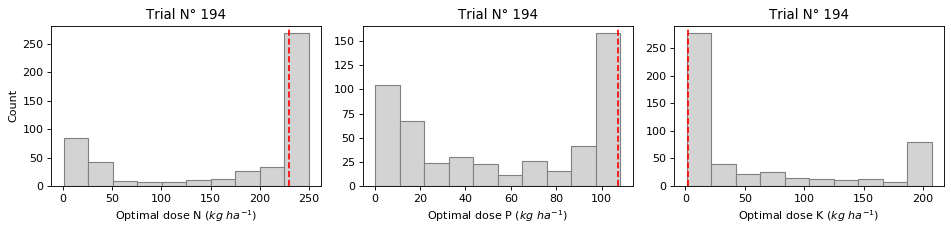

In [114]:
plt.figure(figsize=(12, 3), dpi= 80, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(1, 3, 
                       width_ratios=[1,1,1],
                       height_ratios=[1]
                      ) 
ax0 = plt.subplot(gs[0])
ax0.hist(doses_opt.loc[:, "NtotDose"], color = "lightgrey", edgecolor = 'grey')
ax0.axvline(x = opt_doses_gp[0], color = 'r', linestyle = '--')
ax0.set_title("Trial N° " + str(NoEssai))
ax0.set_xlabel(r"Optimal dose N ($kg~ha^{-1})$")
ax0.set_ylabel("Count")

ax1 = plt.subplot(gs[1])
ax1.hist(doses_opt.loc[:, "P"], color = "lightgrey", edgecolor = 'grey')
ax1.axvline(x = 0.436*opt_doses_gp[1], color = 'r', linestyle = '--')
ax1.set_title("Trial N° " + str(NoEssai))
ax1.set_xlabel("Optimal dose P ($kg~ha^{-1})$")

ax2 = plt.subplot(gs[2])
ax2.hist(doses_opt.loc[:, "K"], color = "lightgrey", edgecolor = 'grey')
ax2.axvline(x = 0.830*opt_doses_gp[2], color = 'r', linestyle = '--')
ax2.set_title("Trial N° " + str(NoEssai))
ax2.set_xlabel(r"Optimal dose K ($kg~ha^{-1})$")

plt.tight_layout();

These distributions show optimal doses (_most of the time_) on the edge of ranges. How can we use this model for decision making while it's difficult to obtain credible optimal dosage? Using the same trial, I generate new tables, one for each fertilizer type, and where one dose is varying while the others are kept constant _at their __gp__ model computed optimum_.

In [115]:
opt_doses_gp

NtotDose    229.63
PtotDose    246.30
KtotDose      2.16
ilr_         -2.75
Name: 492, dtype: float64

#### Prediction where only __N__ dosage varied, trial `r_sample`

In [116]:
dose_grid_N = pd.DataFrame({'NtotDose': np.linspace(0, 250, 251),
                          'PtotDose': opt_doses_gp.PtotDose,
                          'KtotDose': opt_doses_gp.KtotDose})

In [117]:
dose_grid_N_sc = dose_grid_N.copy()
for var in dose_vars:
    dose_grid_N_sc[var] = (dose_grid_N[var] - mean_numvars[var]) / std_numvars[var]

In [118]:
reference_stack_N = pd.DataFrame(index = range(dose_grid_N.shape[0]), columns = reference_row.columns)
for i in range(reference_stack_N.shape[1]):
    reference_stack_N.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack_N.shape[0])
reference_stack_N.NtotDose = dose_grid_N_sc.NtotDose
reference_stack_N.PtotDose = dose_grid_N_sc.PtotDose
reference_stack_N.KtotDose = dose_grid_N_sc.KtotDose  

Point estimate

In [119]:
ilr_N_sc = gpl.predict(reference_stack_N)
dose_grid_N["ilr_"] = ilr_N_sc[:, 0] * std_respvars.values + mean_respvars.values
doses_opt_N_point = dose_grid_N.loc[dose_grid_N["ilr_"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "ilr_"]]#.round(2)
doses_opt_N_point

NtotDose    250.000000
PtotDose    246.300000
KtotDose      2.160000
ilr_         -2.619417
Name: 250, dtype: float64

GP samples

In [120]:
n_gp_samples = 5
gp_samples_N_sc = gpl.sample_y(reference_stack_N, n_samples = n_gp_samples, random_state = 615108)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

# Scale back to original
gp_samples_N = gp_samples_N_sc.copy()
for i in range(n_gp_samples):
    gp_samples_N[:, i] = gp_samples_N_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_ilr_N = pd.DataFrame(gp_samples_N, columns = gp_names)

doses_opt_N_samples = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0, "ilr_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_N_samples.loc[i, ["NtotDose", "PtotDose", "KtotDose"]] = dose_grid_N.loc[gp_ilr_N.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose"]]
    doses_opt_N_samples.loc[i, "ilr_"] = gp_ilr_N.loc[gp_ilr_N.loc[:, i].idxmax(), i]

#### Prediction where only __P__ dosage varied, trial `r_sample`

In [121]:
dose_grid_P = pd.DataFrame({'NtotDose': opt_doses_gp.NtotDose,
                          'PtotDose': np.linspace(0, 250, 251),
                          'KtotDose': opt_doses_gp.KtotDose})

In [122]:
dose_grid_P_sc = dose_grid_P.copy()
for var in dose_vars:
    dose_grid_P_sc[var] = (dose_grid_P[var] - mean_numvars[var]) / std_numvars[var]

In [123]:
reference_stack_P = pd.DataFrame(index = range(dose_grid_P.shape[0]), columns = reference_row.columns)
for i in range(reference_stack_P.shape[1]):
    reference_stack_P.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack_P.shape[0])
reference_stack_P.NtotDose = dose_grid_P_sc.NtotDose
reference_stack_P.PtotDose = dose_grid_P_sc.PtotDose
reference_stack_P.KtotDose = dose_grid_P_sc.KtotDose  

Point estimate

In [124]:
ilr_P_sc = gpl.predict(reference_stack_P)
dose_grid_P["ilr_"] = ilr_P_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_P['P'] = 0.436*dose_grid_P.PtotDose
doses_opt_P_point = dose_grid_P.loc[dose_grid_P["ilr_"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "ilr_"]]#.round(2)
doses_opt_P_point['P'] = 0.436*doses_opt_P_point.PtotDose
doses_opt_P_point

NtotDose    229.630000
PtotDose    250.000000
KtotDose      2.160000
ilr_         -2.735252
P           109.000000
Name: 250, dtype: float64

GP samples

In [125]:
n_gp_samples = 5
gp_samples_P_sc = gpl.sample_y(reference_stack_P, n_samples = n_gp_samples, random_state = 615108)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

# Scale back to original
gp_samples_P = gp_samples_P_sc.copy()
for i in range(n_gp_samples):
    gp_samples_P[:, i] = gp_samples_P_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_ilr_P = pd.DataFrame(gp_samples_P, columns = gp_names)

doses_opt_P_samples = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0, "ilr_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_P_samples.loc[i, ["NtotDose", "PtotDose", "KtotDose"]] = dose_grid_P.loc[gp_ilr_P.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose"]]
    doses_opt_P_samples.loc[i, "ilr_"] = gp_ilr_P.loc[gp_ilr_P.loc[:, i].idxmax(), i]
doses_opt_P_samples["P"] = 0.436*doses_opt_P_samples.PtotDose

#### Prediction where only __K__ dosage varied, trial `r_sample`

In [126]:
dose_grid_K = pd.DataFrame({'NtotDose': opt_doses_gp.NtotDose,
                          'PtotDose': opt_doses_gp.PtotDose,
                          'KtotDose': np.linspace(0, 250, 251)})

In [127]:
dose_grid_K_sc = dose_grid_K.copy()
for var in dose_vars:
    dose_grid_K_sc[var] = (dose_grid_K[var] - mean_numvars[var]) / std_numvars[var]

In [128]:
reference_stack_K = pd.DataFrame(index = range(dose_grid_K.shape[0]), columns = reference_row.columns)
for i in range(reference_stack_K.shape[1]):
    reference_stack_K.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack_K.shape[0])
reference_stack_K.NtotDose = dose_grid_K_sc.NtotDose
reference_stack_K.PtotDose = dose_grid_K_sc.PtotDose
reference_stack_K.KtotDose = dose_grid_K_sc.KtotDose  

Point estimate

In [129]:
ilr_K_sc = gpl.predict(reference_stack_K)
dose_grid_K["ilr_"] = ilr_K_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_K['K'] = 0.830*dose_grid_K.KtotDose
doses_opt_K_point = dose_grid_K.loc[dose_grid_K["ilr_"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "ilr_"]]#.round(2)
doses_opt_K_point['K'] = 0.830*doses_opt_K_point.KtotDose
doses_opt_K_point

NtotDose    229.630000
PtotDose    246.300000
KtotDose      0.000000
ilr_         -2.737158
K             0.000000
Name: 0, dtype: float64

GP samples

In [130]:
n_gp_samples = 5
gp_samples_K_sc = gpl.sample_y(reference_stack_K, n_samples = n_gp_samples, random_state = 615108)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

# Scale back to original
gp_samples_K = gp_samples_K_sc.copy()
for i in range(n_gp_samples):
    gp_samples_K[:, i] = gp_samples_K_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_ilr_K = pd.DataFrame(gp_samples_K, columns = gp_names)

doses_opt_K_samples = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0, "ilr_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_K_samples.loc[i, ["NtotDose", "PtotDose", "KtotDose"]] = dose_grid_K.loc[gp_ilr_K.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose"]]
    doses_opt_K_samples.loc[i, "ilr_"] = gp_ilr_K.loc[gp_ilr_K.loc[:, i].idxmax(), i]
doses_opt_K_samples["K"] = 0.830*doses_opt_K_samples.KtotDose

#### Plot all cases

Results are presented as the average GP and its point optimal dose in blue, with `10` gaussian processes and their optimum. Histograms of probabilistic dosages of maximum ilr values are shown under the response curves.

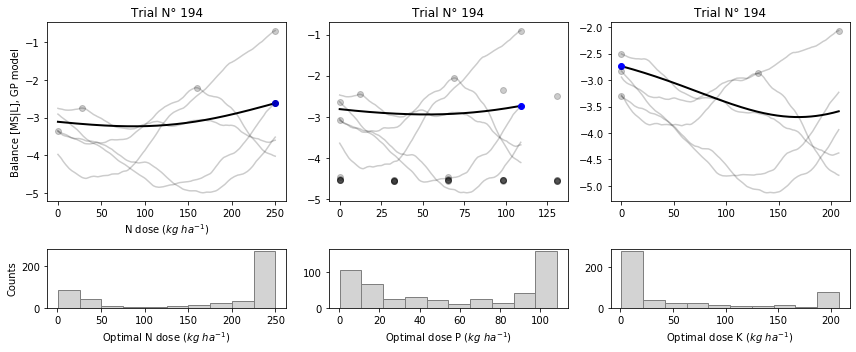

In [131]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1]) 

# N
ax0 = plt.subplot(gs[0])
ax0.plot(dose_grid_N.NtotDose, dose_grid_N.ilr_, linewidth = 2, color = "black")
ax0.plot(doses_opt_N_point.NtotDose, doses_opt_N_point.ilr_, marker = "o", color = "blue")
for i in gp_ilr_N.columns:
    ax0.plot(dose_grid_N.NtotDose, gp_ilr_N[i], color = "black", alpha=0.2)
    ax0.plot(doses_opt_N_samples.loc[i, "NtotDose"], doses_opt_N_samples.loc[i, "ilr_"],
             marker = "o", color = "black", alpha = 0.2)
if r_sample.test_type.values[0] == "N":
    plot_Ndata = df_ml.loc[id_table.NoEssai == r_sample.NoEssai.values[0]][["tsizeMS_L", "NtotDose"]]
    plt.plot(plot_Ndata.NtotDose, plot_Ndata.tsizeMS_L, "o", color = "black", alpha = 0.2)
#ax0.set_ylim([-3, 3])
ax0.set_xlabel(r"N dose ($kg~ha^{-1})$")
ax0.set_ylabel("Balance [MS|L], GP model")
ax0.set_title("Trial N° " + str(NoEssai))

ax1 = plt.subplot(gs[3])
ax1.hist(doses_opt.loc[:, "NtotDose"], color = "lightgrey", edgecolor = 'grey')
ax1.set_xlabel(r"Optimal N dose ($kg~ha^{-1})$")
ax1.set_ylabel("Counts")

# P
ax2 = plt.subplot(gs[1])
ax2.plot(dose_grid_P.P, dose_grid_P.ilr_, linewidth = 2, color = "black")
ax2.plot(doses_opt_P_point.P, doses_opt_P_point.ilr_, marker = "o", color = "blue")
for i in gp_ilr_P.columns:
    ax2.plot(dose_grid_P.P, gp_ilr_P[i], color = "black", alpha=0.2)
    ax2.plot(doses_opt_P_samples.loc[i, "P"], doses_opt_P_samples.loc[i, "ilr_"],
             marker = "o", color = "black", alpha = 0.2)

if r_sample.test_type.values[0] == "P":
    plot_Pdata = df_ml.loc[id_table.NoEssai == r_sample.NoEssai.values[0]][["tsizeMS_L", "PtotDose"]]
    plot_Pdata['P'] = 0.436*plot_Pdata.PtotDose
    plt.plot(plot_Pdata.P, plot_Pdata.tsizeMS_L, "o", color = "black", alpha = 0.2)   
#ax2.set_ylim([-3, 3])
ax2.set_title("Trial N° " + str(NoEssai))

ax3 = plt.subplot(gs[4])
ax3.hist(doses_opt.loc[:, "P"], color = "lightgrey", edgecolor = 'grey')
ax3.set_xlabel(r"Optimal dose P ($kg~ha^{-1})$")

# K
ax4 = plt.subplot(gs[2])
ax4.plot(dose_grid_K.K, dose_grid_K.ilr_, linewidth = 2, color = "black")
ax4.plot(doses_opt_K_point.K, doses_opt_K_point.ilr_, marker = "o", color = "blue")
for i in gp_ilr_K.columns:
    ax4.plot(dose_grid_K.K, gp_ilr_K[i], color = "black", alpha=0.2)
    ax4.plot(doses_opt_K_samples.loc[i, "K"], doses_opt_K_samples.loc[i, "ilr_"],
             marker = "o", color = "black", alpha = 0.2)
if r_sample.test_type.values[0] == "K":
    plot_Kdata = df_ml.loc[id_table.NoEssai == r_sample.NoEssai.values[0]][["tsizeMS_L", "KtotDose"]]
    plot_Kdata['K'] = 0.830*plot_Kdata.KtotDose
    plt.plot(plot_Kdata.K, plot_Kdata.tsizeMS_L, "o", color = "black", alpha = 0.2)   
#ax4.set_ylim([-3, 3])
ax4.set_title("Trial N° " + str(NoEssai))

ax5 = plt.subplot(gs[5])
ax5.hist(doses_opt.loc[:, "K"], color = "lightgrey", edgecolor = 'grey')
ax5.set_xlabel("Optimal dose K ($kg~ha^{-1})$")

plt.tight_layout();

The distributions are almost similar to those from the uniform random grid doses table. Probabilistic optimum are on the edges of ranges corresponding or not to the prior optimum (_blue point_).

### Probabilistic predictions based on __trial type__
These chains make probabilistic predictions for the three N, P and K trials already modeled using `id_sample_n`, `id_sample_p` and `id_sample_k` respectively.

In [132]:
# GP samples
n_gp_samples = 1000 #500
gp_samples_N_sc = gpl.sample_y(reference_stack_N, n_samples = n_gp_samples, random_state = 615108)[:, 0, :]

# Scale back to original
gp_samples_N = gp_samples_N_sc.copy()
for i in range(n_gp_samples):
    gp_samples_N[:, i] = gp_samples_N_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_ilr_N = pd.DataFrame(gp_samples_N, columns = gp_names)

doses_opt_N_samples = pd.DataFrame({"NtotDose":0, "ilr_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_N_samples.loc[i, ["NtotDose"]] = dose_grid_N.loc[gp_ilr_N.loc[:, i].idxmax(), ["NtotDose"]]
    doses_opt_N_samples.loc[i, "ilr_"] = gp_ilr_N.loc[gp_ilr_N.loc[:, i].idxmax(), i]

In [133]:
# GP samples
n_gp_samples = 1000 #500
gp_samples_P_sc = gpl.sample_y(reference_stack_P, n_samples = n_gp_samples, random_state = 615108)[:, 0, :]

# Scale back to original
gp_samples_P = gp_samples_P_sc.copy()
for i in range(n_gp_samples):
    gp_samples_P[:, i] = gp_samples_P_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_ilr_P = pd.DataFrame(gp_samples_P, columns = gp_names)

doses_opt_P_samples = pd.DataFrame({"PtotDose":0, "ilr_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_P_samples.loc[i, ["PtotDose"]] = dose_grid_P.loc[gp_ilr_P.loc[:, i].idxmax(), ["PtotDose"]]
    doses_opt_P_samples.loc[i, "ilr_"] = gp_ilr_P.loc[gp_ilr_P.loc[:, i].idxmax(), i]
doses_opt_P_samples["P"] = 0.436*doses_opt_P_samples.PtotDose

In [134]:
# GP samples
n_gp_samples = 1000 #500
gp_samples_K_sc = gpl.sample_y(reference_stack_K, n_samples = n_gp_samples, random_state = 615108)[:, 0, :]

# Scale back to original
gp_samples_K = gp_samples_K_sc.copy()
for i in range(n_gp_samples):
    gp_samples_K[:, i] = gp_samples_K_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_ilr_K = pd.DataFrame(gp_samples_K, columns = gp_names)

doses_opt_K_samples = pd.DataFrame({"KtotDose":0, "ilr_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_K_samples.loc[i, ["KtotDose"]] = dose_grid_K.loc[gp_ilr_K.loc[:, i].idxmax(), ["KtotDose"]]
    doses_opt_K_samples.loc[i, "ilr_"] = gp_ilr_K.loc[gp_ilr_K.loc[:, i].idxmax(), i]
doses_opt_K_samples["K"] = 0.830*doses_opt_K_samples.KtotDose

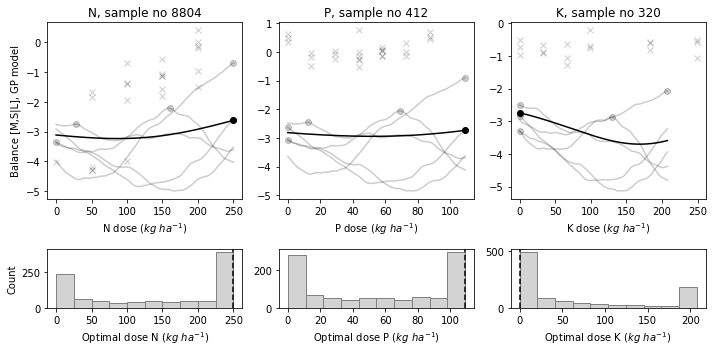

In [135]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 3, 
                       width_ratios=[1,1,1],
                       height_ratios=[3, 1]
                      ) 
# N
ax0 = plt.subplot(gs[0])
ax0.plot(dose_grid_N.NtotDose, dose_grid_N.ilr_, "-", color = "black")
ax0.plot(Ndata.NtotDose, Ndata.tsizeMS_L, "x", color = "black", alpha = 0.2)
ax0.plot(doses_opt_N_point.NtotDose, doses_opt_N_point.ilr_, marker = "o", color = "black")
for i in gp_ilr_N.columns[0:5]:
    ax0.plot(dose_grid_N.NtotDose, gp_ilr_N[i], color = "black", alpha=0.2)
    ax0.plot(doses_opt_N_samples.loc[i, "NtotDose"], doses_opt_N_samples.loc[i, "ilr_"],
             marker = "o", color = "black", alpha = 0.2)
#ax0.set_ylim([-1.5, 1.5])
ax0.set_xlabel(r"N dose ($kg~ha^{-1})$")
ax0.set_ylabel("Balance [M,S|L], GP model")
ax0.set_title("N, sample no " + str(id_sample_n.NoEssai.values[0]))

ax1 = plt.subplot(gs[3])
ax1.hist(doses_opt_N_samples.loc[:, "NtotDose"], color = "lightgrey", edgecolor = 'grey')
ax1.axvline(x = doses_opt_N_point.NtotDose, color = 'black', linestyle = '--')
ax1.set_xlabel(r"Optimal dose N ($kg~ha^{-1})$")
ax1.set_ylabel("Count")

# P
ax2 = plt.subplot(gs[1])
ax2.plot(dose_grid_P.P, dose_grid_P.ilr_, "-", color = "black")
ax2.plot(Pdata.P, Pdata.tsizeMS_L, "x", color = "black", alpha = 0.2)
ax2.plot(doses_opt_P_point.P, doses_opt_P_point.ilr_, marker = "o", color = "black")
for i in gp_ilr_P.columns[0:5]:
    ax2.plot(dose_grid_P.P, gp_ilr_P[i], color = "black", alpha=0.2)
    ax2.plot(doses_opt_P_samples.loc[i, "P"], doses_opt_P_samples.loc[i, "ilr_"],
             marker = "o", color = "black", alpha = 0.2)
#ax2.set_ylim([-1.5, 1.5])
ax2.set_xlabel(r"P dose ($kg~ha^{-1})$")
ax2.set_title("P, sample no " + str(id_sample_p.NoEssai.values[0]))

ax3 = plt.subplot(gs[4])
ax3.hist(doses_opt_P_samples.loc[:, "P"], color = "lightgrey", edgecolor = 'grey')
ax3.axvline(x = doses_opt_P_point.P, color = 'black', linestyle = '--')
ax3.set_xlabel(r"Optimal dose P ($kg~ha^{-1})$")

# K
ax4 = plt.subplot(gs[2])
ax4.plot(dose_grid_K.K, dose_grid_K.ilr_, "-", color = "black")
ax4.plot(Kdata.K, Kdata.tsizeMS_L, "x", color = "black", alpha = 0.2)
ax4.plot(doses_opt_K_point.K, doses_opt_K_point.ilr_, marker = "o", color = "black")
for i in gp_ilr_K.columns[0:5]:
    ax4.plot(dose_grid_K.K, gp_ilr_K[i], color = "black", alpha=0.2)
    ax4.plot(doses_opt_K_samples.loc[i, "K"], doses_opt_K_samples.loc[i, "ilr_"],
             marker = "o", color = "black", alpha = 0.2)
#ax4.set_ylim([-1.5, 1.5])
ax4.set_xlabel(r"K dose ($kg~ha^{-1})$")
ax4.set_title("K, sample no " + str(id_sample_k.NoEssai.values[0]))

ax5 = plt.subplot(gs[5])
ax5.hist(doses_opt_K_samples.loc[:, "K"], color = "lightgrey", edgecolor = 'grey')
ax5.axvline(x = doses_opt_K_point.K, color = 'black', linestyle = '--')
ax5.set_xlabel(r"Optimal dose K ($kg~ha^{-1})$")

plt.tight_layout();
plt.savefig("images/MSL_probab_doses.png", bbox_inches = "tight", dpi = 300)

In [102]:
index = ["NtotDose", "PtotDose", "KtotDose", "ilr_"]
opt_points = pd.DataFrame({"N trial": doses_opt_N_point,
                           "P trial": doses_opt_P_point,
                           "K trial": doses_opt_K_point},
                          index = index)
opt_points

,N trial,P trial,K trial
NtotDose,142.00,137.35,137.35
PtotDose,200.92,199.00,200.92
KtotDose,209.42,209.42,222.00
ilr_,0.02,0.02,0.03
